In [2]:
from langchain.chat_models import init_chat_model
from typing import Annotated
from typing_extensions import TypedDict, Dict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
# from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from dotenv import load_dotenv
import os 
from langchain.tools import tool



load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")
memory = MemorySaver()



## our work  flow

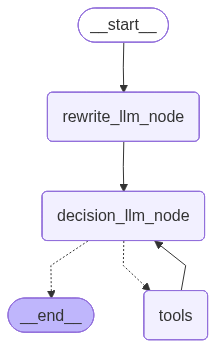

In [ ]:
from langchain.chat_models import init_chat_model
from typing import Annotated
from typing_extensions import TypedDict, Dict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
# from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from dotenv import load_dotenv
import os 
from langchain.tools import tool



load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")
memory = MemorySaver()



class State(TypedDict):
    query:  str
    rewrite_query:   str
    sql_retrieved_data: str
    vdb_retrieved_data: str
    feedback:   str
# done
def rewrite_llm(state: State)    -> Dict[str, str]:
    return {"rewrite_query": "cleaned query from LLM"}
    
def decision_llm(state: State)  ->  str:
    if "patient" in state["rewrite_query"].lower():
        return "sql"
    else:
        return "vdb"
#done
@tool
def sql_agent_llm(state:    State)->    str:
    """Run SQL agent"""
    return f"SQL results for {state['query']}"

# done
def hybrid_retrieval(state: State)->    Dict[str, str]:
    """ return  the query """

    return {"vdb_retrieved_data": "reranked docs"}


llm = init_chat_model('gpt-4o-mini')

tools = [sql_agent_llm,hybrid_retrieval]

llm_with_tools = llm.bind_tools(tools)

def chatbot(state:State)->  str:
    return {"Messages":[llm_with_tools.invoke(state["query"])]}

builder = StateGraph(State)

builder.add_node("rewrite_llm_node",rewrite_llm)
builder.add_node("decision_llm_node", decision_llm)
builder.add_node('tools',ToolNode(tools))

builder.add_edge(START, "rewrite_llm_node")
builder.add_edge('rewrite_llm_node',"decision_llm_node")
builder.add_conditional_edges("decision_llm_node", tools_condition)
builder.add_edge("tools",'decision_llm_node')

graph = builder.compile(checkpointer=memory)
graph

# llm  given flow 

In [ ]:
from typing import TypedDict, Dict
from langgraph.graph import StateGraph
from langchain_core.tools import tool
from langgraph.graph import END, START


# Define shared state
class State(TypedDict):
    query: str
    rewrite_query: str
    sql_retrieved_data: str
    vdb_retrieved_data: str
    feedback: str

# Step 1: Rewrite query
def rewrite_llm(state: State) -> Dict[str, str]:
    return {"rewrite_query": "cleaned query from LLM"}

# Step 2: Decide which tool to use
def decision_llm(state: State) -> str:
    if "patient" in state["rewrite_query"].lower():
        return sql_agent_llm
    else:
        return hybrid_retrieval

# Step 3a: SQL agent tool
@tool
def sql_agent_llm(
    query: str,
    rewrite_query: str,
    sql_retrieved_data: str,
    vdb_retrieved_data: str,
    feedback: str
) -> Dict[str, str]:
    """tool"""
    return {"sql_retrieved_data": f"SQL results for query: {query}"}

# Step 3b: VDB retrieval tool
@tool
def hybrid_retrieval(
    query: str,
    rewrite_query: str,
    sql_retrieved_data: str,
    vdb_retrieved_data: str,
    feedback: str
) -> Dict[str, str]:
    """tool"""
    return {"vdb_retrieved_data": "reranked docs from VDB"}

# Conditional routing function
def tools_condition(output: str) -> str:
    return output  # output is already the node name

# Build the graph
builder = StateGraph(State)

# Add nodes
builder.add_node("rewrite_llm_node", rewrite_llm)
builder.add_node("decision_llm_node", decision_llm)
builder.add_node("sql_agent_llm", sql_agent_llm)
builder.add_node("hybrid_retrieval", hybrid_retrieval)

# Add edges
builder.add_edge(START, "rewrite_llm_node")
builder.add_edge("rewrite_llm_node", "decision_llm_node")
builder.add_conditional_edges("decision_llm_node", tools_condition)
builder.add_edge("sql_agent_llm", END)
builder.add_edge("hybrid_retrieval", END)

# Compile the graph
graph = builder.compile()

# Dummy input state
state = {
    "query": "Show me patient records",
    "rewrite_query": "",
    "sql_retrieved_data": "",
    "vdb_retrieved_data": "",
    "feedback": ""
}

# Run the graph
final_output = graph.invoke(state)
print(final_output)

Task decision_llm_node with path ('__pregel_pull', 'decision_llm_node') wrote to unknown channel branch:to:{'vdb_retrieved_data': 'reranked docs from VDB', 'query': 'Show me patient records', 'rewrite_query': 'cleaned query from LLM', 'sql_retrieved_data': '', 'feedback': ''}, ignoring it.


{'query': 'Show me patient records', 'rewrite_query': 'cleaned query from LLM', 'sql_retrieved_data': '', 'vdb_retrieved_data': 'reranked docs from VDB', 'feedback': ''}


In [18]:
final_output

{'query': 'Show me patient records',
 'rewrite_query': 'cleaned query from LLM',
 'sql_retrieved_data': '',
 'vdb_retrieved_data': 'reranked docs from VDB',
 'feedback': ''}

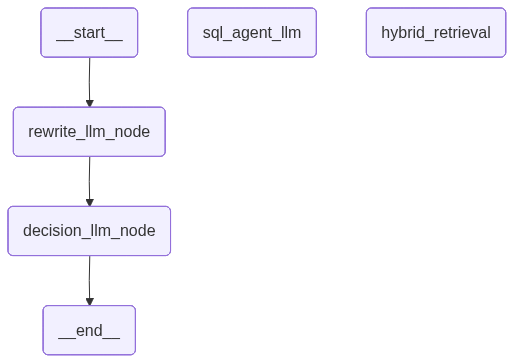

In [20]:
graph